# Global Regression Analysis
Taking a look at what comes out from the global regression.

**NOTE**: The native grid output does not plot well globally, especially for contour mapping. Thus, I've embedded a cdo function to temporarily remap the output of interest to a 1deg by 1deg standard grid globally.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ocn-clim')

import cmocean.cm as cm
import cartopy.crs as ccrs
import esmtools as et

In [2]:
def meshgrid(x, y, d):
    (xx, yy) = np.meshgrid(x, y)
    d.coords['gridlon'] = (('lat', 'lon'), xx)
    d.coords['gridlat'] = (('lat', 'lon'), yy)
    return d

In [41]:
EBU = 'HumCS'
VAR = 'SST'
ENS = '009'
LAG = 6

In [42]:
filepath = ('/glade/p/work/rbrady/EBUS_BGC_Variability/global_regressions/' + VAR + '/' +
            EBU + '/lag' + str(LAG) + '/remapped/remapped.' +  VAR + '.FG_ALT_CO2.' + EBU + '.' + ENS +
            '.smoothed_global_regression.lag' + str(LAG) + '.nc')

In [43]:
ds = xr.open_dataset(filepath)
# Turn 1D grids into meshgrid
ds = meshgrid(ds.lon, ds.lat, ds)
# Mask out insignificant
ds.r[ds.p > 0.05] = np.nan
ds.m[ds.p > 0.05] = np.nan
# Make colormap
cmap = et.vis.discrete_cmap(20, cm.balance)
cmap.set_under('#A9A9A9')

/glade/u/home/rbrady/.local/lib/python3.6/site-packages/xarray/core/variable.py:1193: RuntimeWarning: invalid value encountered in greater
  if not reflexive


/glade/u/home/rbrady/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


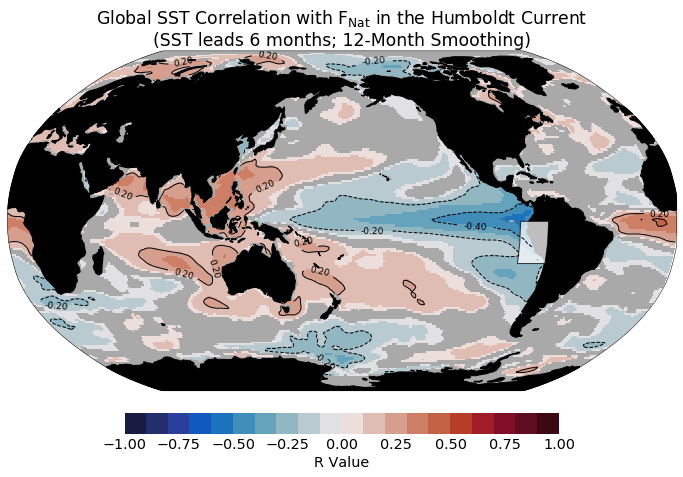

In [44]:
f, ax = et.vis.make_cartopy(projection=ccrs.Robinson(central_longitude=180),
                            grid_lines=False)

# Pcolor background.
plt.pcolormesh(ds['gridlon'], ds['gridlat'], ds['r'], transform=ccrs.PlateCarree(),
               vmin=-1, vmax=1, cmap=cmap)
cb = plt.colorbar(orientation='horizontal', pad=0.05, fraction=0.05)

# Contours.
cs = ax.contour(ds['gridlon'], ds['gridlat'], ds['r'], transform=ccrs.PlateCarree(),
                linewidths=1, colors='k', levels=np.linspace(-1,1,11))
fmt = '%.2f'
plt.clabel(cs, fontsize=9, inline=1, fmt=fmt)

# Box.
x0, x1, y0, y1 = et.ebus.visual_bounds(EBU, std_lon=True)
et.vis.add_box(ax, x0, x1, y0, y1, facecolor='w', edgecolor='k',
               linewidth=2, alpha=0.75)

# Labels.
ax.set_title('Global SST Correlation with F$_{\mathrm{Nat}}$' +
             ' in the Humboldt Current' + '\n' + '(' + VAR + ' leads ' +
             str(LAG) + ' months; 12-Month Smoothing)')
cb.set_label('R Value')